In [1]:
import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt
from problems.ising_problem import IsingProblem
from cost_function import cost_loc
from hyperparameters import *

In [2]:
# Note: J, zeta, eta_ising affect the ising model and are fixed in the paper.
problem = IsingProblem(
    n_qubits=4,
    J=0.1,
    # TODO: convert to dependence on condition number k instead of these params
    zeta=8.1,
    eta_ising=4.1
)
n_qubits = problem.get_n_qubits()

In [3]:
problem.get_condition_number()

198.59186

In [4]:
w = q_delta * np.random.randn(7*n_qubits, requires_grad=True)

In [5]:
dev_mu = qml.device("default.qubit", wires=n_qubits+1)

In [6]:
opt = qml.GradientDescentOptimizer(eta)

cost_history = []
for it in range(steps):
    w, cost = opt.step_and_cost(lambda w: cost_loc(problem, w, dev_mu), w)
    print("Step {:3d}       Cost_L = {:9.7f}".format(it, cost))
    cost_history.append(cost)

mu sum accum (0): 0.052
mu sum accum (1): 0.045
mu sum accum (2): 0.043
mu sum accum (3): 0.044
mu sum accum (8): 0.044
mu sum accum (9): 0.045
mu sum accum (10): 0.045
mu sum accum (11): 0.118
mu sum accum (16): 0.046
mu sum accum (17): 0.045
mu sum accum (18): 0.070
mu sum accum (19): 0.074
mu sum accum (24): 0.046
mu sum accum (25): 0.045
mu sum accum (26): 0.046
mu sum accum (27): 0.046
mu sum accum (32): 0.045
mu sum accum (33): 0.151
mu sum accum (34): 0.059
mu sum accum (35): 0.053
mu sum accum (40): 0.048
mu sum accum (41): 0.045
mu sum accum (42): 0.047
mu sum accum (43): 0.048
mu sum accum (48): 0.051
mu sum accum (49): 0.049
mu sum accum (50): 0.198
mu sum accum (51): 0.056
mu sum accum (56): 0.052
mu sum accum (57): 0.046
mu sum accum (58): 0.049
mu sum accum (59): 0.051
mu sum accum (64): 0.057
mu sum accum (65): 0.066
mu sum accum (66): 0.059
mu sum accum (67): 0.050
mu sum accum (72): 0.048
mu sum accum (73): 0.048
mu sum accum (74): 0.220
mu sum accum (75): 0.046
mu sum

### Optimization studies:
- each epoch is taking ~ 20s
- Each $\mu$ calculation takes ~0.05s but occasionally spikes to ~0.3s
- Each $\mu_{sum}$ has to loop over each combination of A_l for each qubit -> $c^2n$ operations -> ~15s
- Each $|\psi|$ also has to loop over each combination, but we're unable to recycle computation because these don't apply $CZ$ like the above -> ~4s
- TODO: figure out why `len(c) = 8` and not 3
- TODO: figure out why there are 508 mu_sum accumulations

/var/folders/46/x_y_zr5s2rj1v37fwfjmjh9r0000gn/T/ipykernel_45540/1714839985.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


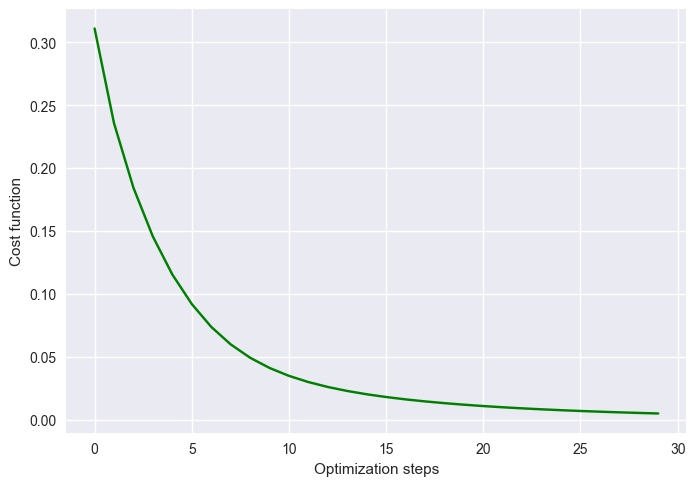

In [6]:
plt.style.use("seaborn")
plt.plot(cost_history, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

Qualitatively, it's converging slower than the toy problem, suggesting more iterations are needed

In [7]:
from inference import get_cprobs, get_qprobs
c_probs = get_cprobs(problem)

dev_x = qml.device("default.qubit", wires=n_qubits, shots=n_shots)
q_probs = get_qprobs(problem, w, dev_x)

/Users/bigsad/Downloads/Algorithm-Research/Student-Hub/Indy-Ng/.venv/lib/python3.11/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'problems'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


/Users/bigsad/Downloads/Algorithm-Research/Student-Hub/Indy-Ng/.venv/lib/python3.11/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


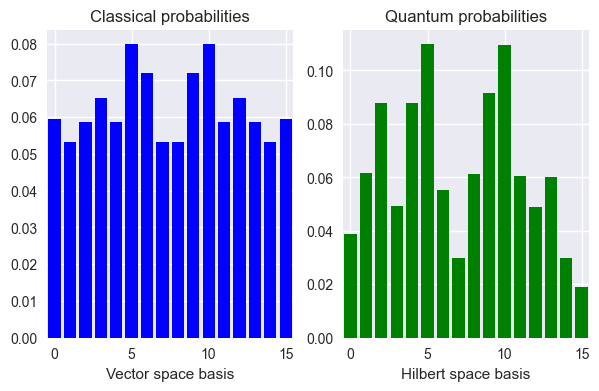

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()